In [1]:
import pandas as pd
import igraph as ig
from ipysigma import Sigma
import glob
import json
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Comparison on three iteration

In [2]:
edgelist_incel = pd.DataFrame(columns=['forward_from','forward_to','count'])

for path in glob.glob('./incel*/*_edgelist/*edgelist*.csv'):
    df = pd.read_csv(path)
    edgelist_incel = pd.concat([edgelist_incel,df])

In [3]:
edgelist_incel['link'] = ['incel']*len(edgelist_incel)

In [4]:
edgelist_right = pd.DataFrame(columns=['forward_from','forward_to','count'])

for path in glob.glob('./*right*/*_edgelist/*edgelist*.csv'):
    df = pd.read_csv(path)
    edgelist_right = pd.concat([edgelist_right,df])

In [5]:
edgelist_right['link'] = ['right']*len(edgelist_right)

In [6]:
edgelist_left = pd.DataFrame(columns=['forward_from','forward_to','count'])

for path in glob.glob('./*left*/*_edgelist/*edgelist*.csv'):
    df = pd.read_csv(path)
    edgelist_left = pd.concat([edgelist_left,df])

In [7]:
edgelist_left['link'] = ['left']*len(edgelist_left)

In [8]:
edgelist = pd.concat([edgelist_incel, edgelist_left, edgelist_right])

In [9]:
with open('./incel_network/dictionaires/id_to_desc.json') as file_desc,\
    open('./incel_network/dictionaires/id_to_names.json') as file_names:
    id_to_desc_incel = json.load(file_desc)
    id_to_names_incel = json.load(file_names)

In [10]:
with open('./extreme_right_network/dictionaires/id_to_desc.json') as file_desc,\
    open('./extreme_right_network/dictionaires/id_to_names.json') as file_names:
    id_to_desc_right = json.load(file_desc)
    id_to_names_right = json.load(file_names)

In [11]:
with open('./extreme_left_network/dictionaires/id_to_desc.json') as file_desc,\
    open('./extreme_left_network/dictionaires/id_to_names.json') as file_names:
    id_to_desc_left = json.load(file_desc)
    id_to_names_left = json.load(file_names)

In [12]:
id_to_desc_incel = dict(map(lambda x: (int(x[0]), x[1]), id_to_desc_incel.items()))
id_to_desc_right = dict(map(lambda x: (int(x[0]), x[1]), id_to_desc_right.items()))
id_to_desc_left = dict(map(lambda x: (int(x[0]), x[1]), id_to_desc_left.items()))

id_to_names_incel = dict(map(lambda x: (int(x[0]), x[1]), id_to_names_incel.items()))
id_to_names_right = dict(map(lambda x: (int(x[0]), x[1]), id_to_names_right.items()))
id_to_names_left = dict(map(lambda x: (int(x[0]), x[1]), id_to_names_left.items()))

In [13]:
id_to_names = {**id_to_names_incel, **id_to_names_right, ** id_to_names_left}
id_to_desc = {**id_to_desc_incel, **id_to_desc_right, **id_to_desc_left}

### Function def

In [14]:
count_links = np.vectorize(lambda x: x['link'])
count_weights = np.vectorize(lambda x: x['weight'])

In [15]:

def get_links_within_community(community, list_links, graph):
    """"
    community: list of nodes part of a community
    list_links: edgelist of tuple (node_source, node_target)
    graph = igraph graph

    returns the share of edges that are "incel" or "right/left" on the total, weighting on the edges weight
    """

    if len(community)==1:
        return np.nan

    mask = []
    for link in list_links:
        true_or_false = link[0] in community and link[1] in community
        mask.append(true_or_false)
    
    links_in_community = np.array(list(graph.es))[mask]

    list_of_pairs = list(zip(count_links(links_in_community), count_weights(links_in_community))) #get array of pairs (category, weight)

    
    temp_df = pd.DataFrame(list_of_pairs).groupby(0).sum().sort_values(by=1,ascending=False)
    total = temp_df.sum()

    share_highest_value = (temp_df/total).iloc[0,0]

    return share_highest_value

    

In [16]:
def get_average(G,communities, n_filter=None, n_communities=None, weighted=True):

    """
    Get the share of highest tyoe of link ("incel" or "right/left") for several communities in the network and averages
    the results, weighting with the number of nodes in each community.

    G: graph
    communities: VertexCluster object
    n_filter = minumum number of nodes in a community to be considered. Default all
    n_communities = if not None, we consider only the n first communities with most nodes

    (n_filter and n_communities together raises an error)

    returns a number between 0 and 1. The closer to 1, the more separate are the communities
    """

    list_communities = np.unique(G.vs['community'])

    list_of_links = list(map(lambda x: x.tuple, G.es))

    if n_filter is not None:
        list_communities = list(filter(lambda x: len(communities[x])>n_filter, list_communities))

    if n_communities is not None:
        list_communities = sorted(np.unique(G.vs['community']), key=lambda x: len(communities[x]), reverse=True)[:n_communities]

    print(f'Calculating average for a total of {len(list_communities)} communities')

    shares_communities = []
    for community_number in list_communities:
        highest_share = get_links_within_community(communities[community_number], list_of_links, G)
        shares_communities.append((community_number, highest_share))
        

    if weighted:
        weights = list(map(lambda x: len(communities[x[0]]), shares_communities))
    
    else:
        weights = np.ones(len(shares_communities)) #list of weights is a list of ones. So it's like NO WEIGHTS
        
    final_shares = list(map(lambda x: x[1], shares_communities))


    weights = np.array(weights)[~np.isnan(final_shares)] #let's drop nan (aka communities with just one node)

    final_shares = np.array(final_shares)[~np.isnan(final_shares)] #let's drop nan (aka communities with just one node)

    return np.average(final_shares, weights=weights)

### right-incel

In [17]:
edgelist_ir = edgelist[(edgelist['link']=='incel') | (edgelist['link']=='right')]

In [18]:
G_ir = ig.Graph.TupleList(edgelist_ir.iloc[:,:3].itertuples(index=False), directed=True, weights=True)

In [25]:
## community detection
#communities = G_ir.as_undirected().community_leiden(objective_function="modularity")
communities = G_ir.community_walktrap(weights= G_ir.es['weight'], steps=5)
# add community as node label
communities_ir = communities.as_clustering()
G_ir.vs['community'] = communities_ir.membership

In [20]:
G_ir.es['link'] = edgelist_ir['link'].to_list()

In [21]:
(get_average(G_ir, communities_ir,n_communities=10, weighted=True)-0.5)/0.5

Calculating average for a total of 10 communities


0.8013517667850345

### left-incel

In [22]:
edgelist_il = edgelist[(edgelist['link']=='incel') | (edgelist['link']=='left')]
G_il = ig.Graph.TupleList(edgelist_il.iloc[:,:3].itertuples(index=False), directed=True, weights=True)
## community detection
#communities = G_il.as_undirected().community_leiden(objective_function="modularity")
communities = G_il.community_walktrap(weights= G_il.es['weight'], steps=5)
# add community as node label
communities_il = communities.as_clustering()

G_il.vs['community'] = communities_il.membership

G_il.es['link'] = edgelist_il['link'].to_list()

In [23]:
(get_average(G_il, communities_il, n_communities=10,weighted=True)-0.5)/0.5

Calculating average for a total of 10 communities


0.9469263584916556

### left-right

In [24]:
edgelist_lr = edgelist[(edgelist['link']=='right') | (edgelist['link']=='left')]
G_lr = ig.Graph.TupleList(edgelist_lr.iloc[:,:3].itertuples(index=False), directed=True, weights=True)
## community detection
#communities = G_lr.as_undirected().community_leiden(objective_function="modularity")
communities = G_lr.community_walktrap(weights= G_lr.es['weight'], steps=5)
# add community as node label
communities_lr = communities.as_clustering()

G_lr.vs['community'] = communities_lr.membership

G_lr.es['link'] = edgelist_lr['link'].to_list()

In [25]:
(get_average(G_lr, communities_lr, n_communities=10)-0.5)/0.5

Calculating average for a total of 10 communities


0.7656526260299543

### visual comparison

In [26]:
def get_index_list(G,communities, sort_list=True):

    """
    Get the share of highest tyoe of link ("incel" or "right/left") for several communities in the network and returns a list

    G: graph
    communities: VertexCluster object
    sorted: bool

    If sorted=True, list is in order of number of nodes

    returns a list of tuple (weights, final_shares) where weights is the list of number of nodes
    """

    list_communities = np.unique(G.vs['community'])

    list_of_links = list(map(lambda x: x.tuple, G.es))

    if sort_list:
        list_communities = sorted(np.unique(G.vs['community']), key=lambda x: len(communities[x]), reverse=True)

    print(f'Calculating average for a total of {len(list_communities)} communities')

    shares_communities = []
    for community_number in list_communities:
        highest_share = get_links_within_community(communities[community_number], list_of_links, G)
        shares_communities.append((community_number, highest_share))

    weights = list(map(lambda x: len(communities[x]), list_communities))
    final_shares = list(map(lambda x: x[1], shares_communities))

    assert len(weights)==len(final_shares)

    return weights, final_shares

In [27]:
index_ir = get_index_list(G_ir, communities_ir)
index_il = get_index_list(G_il, communities_il)
#index_lr = get_index_list(G_lr, communities_lr)


Calculating average for a total of 117 communities
Calculating average for a total of 153 communities


In [28]:
np.average(index_ir[1][:10], weights=index_ir[0][:10])

0.9006758833925173

In [29]:
averages_ir = []
averages_il = []
#averages_lr = []

for n in range(1,101):
    averages_ir.append(np.average(index_ir[1][:n], weights=index_ir[0][:n]))
    averages_il.append(np.average(index_il[1][:n], weights=index_il[0][:n]))
    #averages_lr.append(np.average(index_lr[1][:n], weights=index_lr[0][:n]))

In [30]:
averages_ir = (((np.array(averages_ir))-0.5)/0.5)*100
averages_il = (((np.array(averages_il))-0.5)/0.5) *100
#averages_lr = ((np.array(averages_lr))-0.5)/0.5

# normalization

In [31]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=12)
rc('font', family='Times New Roman')
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')

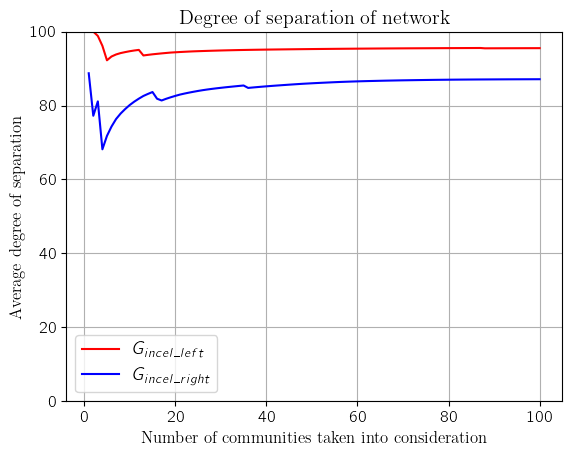

In [32]:
plt.plot(range(1,101), averages_il, label='$G_{incel\_left}$', color='red')
plt.plot(range(1,101), averages_ir, label='$G_{incel\_right}$', color='blue')
plt.ylim((0,100))
plt.ylabel('Average degree of separation')
plt.xlabel('Number of communities taken into consideration')

plt.title('Degree of separation of network')
plt.grid(True)
plt.legend()
plt.savefig('../report_latex/img/average_degree.png',dpi=300)
plt.show()